In [2]:
#!pip install optuna

In [3]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import OneHotEncoder

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Import Data

In [4]:
train = pd.read_csv('/content/drive/MyDrive/손동작 분류/train.csv')
test = pd.read_csv('/content/drive/MyDrive/손동작 분류/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/손동작 분류/sample_submission.csv')

train.shape, test.shape, submission.shape

((2335, 34), (9343, 33), (9343, 2))

### CNN Modeling

In [5]:
train_X = train.iloc[:, 1:-1] # id, target 컬럼 제거
test_X = test.iloc[:, 1:]

train_X = np.array(train_X).reshape(-1, 8, 4, 1)
test_X = np.array(test_X).reshape(-1, 8, 4, 1)

oh = OneHotEncoder(sparse = False)
train_y = oh.fit_transform(train[['target']])

In [6]:
train_X.shape, test_X.shape, train_y.shape

((2335, 8, 4, 1), (9343, 8, 4, 1), (2335, 4))

### 활성화 함수
- 딥러닝 네트워크에서 노드에 입력된 값들을 비선형 함수에 통과시킨 후 다음 레이어로 전달하는데, 이 때 사용하는 함수를 활성화 함수(Activation Function)라고 한다. 선형 함수가 아니라 비선형 함수를 사용하는 이유는 딥러닝 모델의 레이어 층을 깊게 가져갈 수 있기 때문이다.

- Sigmoid : 입력 값을 0과 1 사이의 값으로 변환하여 출력

---



---


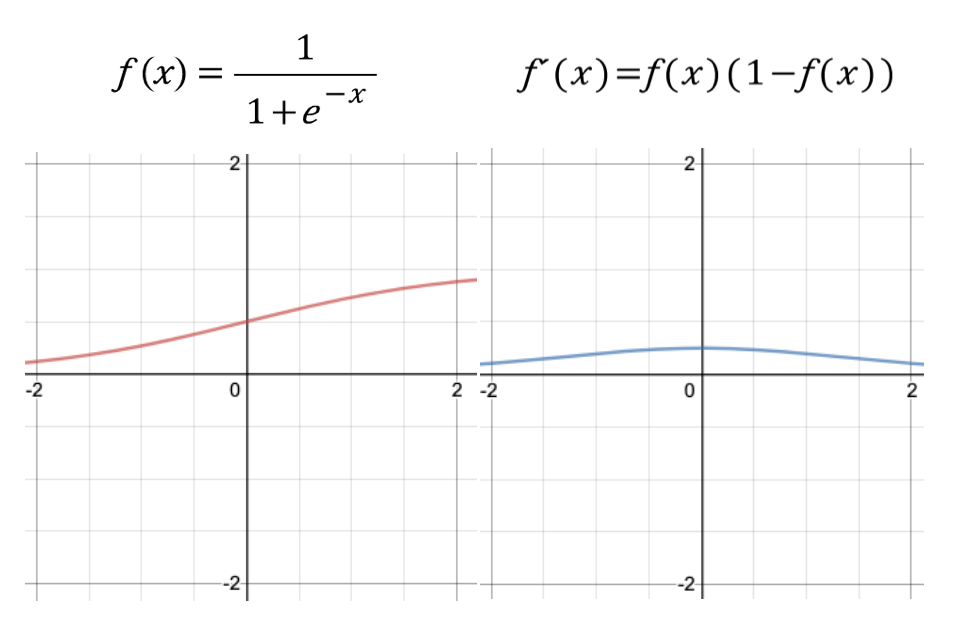

- ReLU : 0 이하의 값은 다음 레이어에 전달 X, 0 이상의 값은 그대로 출력
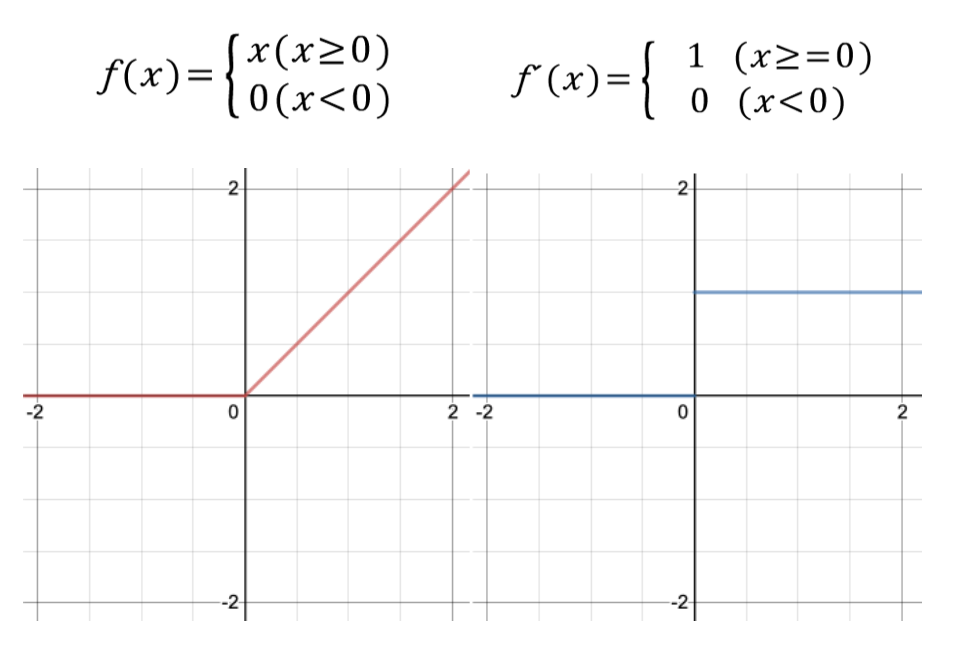

- LeakyReLU : ReLU와 거의 비슷한 형태. 입력 값이 음수일 때 완만한 선형 함수. 일반적으로 알파를 0.01로 설정
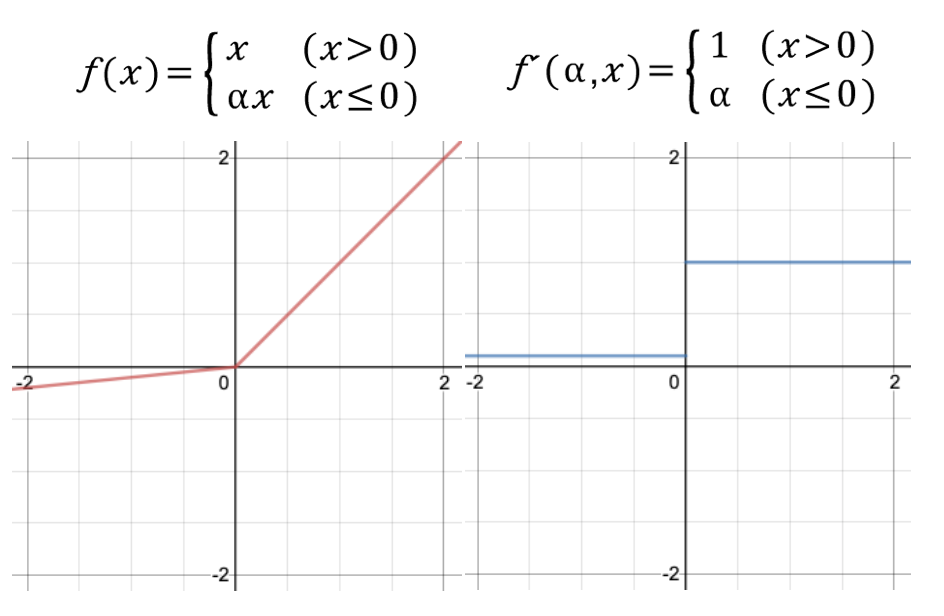

- ELU : ReLU와 거의 비슷한 형태를 가짐. 지수 함수를 이용하여 입력이 0 이하일 경우 부드럽게 깎아줌. 미분 함수가 끊어지지 않고 이어져 있는 형태를 보임
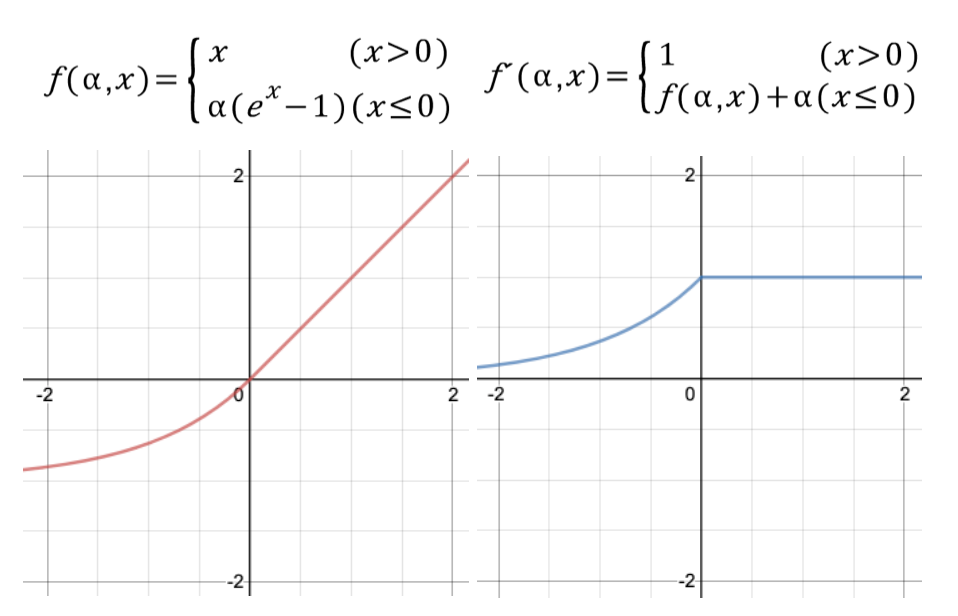



In [41]:
def create_model(num_layer, mid_units, num_filters):
    
    model = Sequential()
    model.add(Conv2D(filters=num_filters[0], kernel_size=(2, 2),
                 activation="elu",
                 input_shape=(8, 4, 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    for i in range(1,num_layer):
        model.add(Conv2D(filters=num_filters[i], kernel_size=(2, 2), padding="same", activation="elu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(mid_units, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(4, activation='softmax'))
    
    return model

In [44]:
def cnn_objective(trial : Trial) -> float:
  # 세션 지우기
  keras.backend.clear_session()
  
  # 컨볼루션 레이어 수의 매개변수
  num_layer = trial.suggest_int('num_layer', 2, 4)

  # FC 레이어 유닛 수
  mid_units = int(trial.suggest_discrete_uniform('mid_units', 30, 180, 5))

  # 각 컨볼루션 레이어의 필터 수
  num_filters = [int(trial.suggest_discrete_uniform('num_filter_' + str(i), 16, 256, 16)) for i in range(num_layer)]

  # Dropout
  #dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
  #dropout_rate = [int(trial.suggest_uniform('dropout_rate'+str(ii), 0.0, 0.5)) for ii in range(num_layer+1)]

  seed = 42
  kfold = StratifiedKFold(n_splits = 5, random_state = seed, shuffle = True)
  es = EarlyStopping(monitor = 'val_acc', patience = 5, mode = 'max', verbose = 0)
  cv = np.zeros((train_X.shape[0], 4))

  for n, (train_idx, val_idx) in enumerate(kfold.split(train_X, train['target'])):

    X_tr, y_tr = train_X[train_idx], train_y[train_idx]
    X_val, y_val = train_X[val_idx], train_y[val_idx]

    mc = ModelCheckpoint(f'model_{n+1}.h5', save_best_only = True, monitor = 'val_acc', mode = 'max', verbose = 0)

    model = create_model(num_layer, mid_units, num_filters)

    optimizer = Adam(learning_rate = trial.suggest_uniform('learning_rate', 0.0005, 0.001))
    model.compile(optimizer = optimizer,
                  loss = 'categorical_crossentropy',
                  metrics = ['acc'])
    model.fit(X_tr, y_tr, validation_data = (X_val, y_val), epochs = 50, batch_size = 16, callbacks = [es, mc], verbose = None)

    best = load_model(f'model_{n+1}.h5')

    cv[val_idx, :] = best.predict(X_val)

  print('multi_logloss : ', log_loss(train_y, cv)) # 손실 함수
  print('accuracy_score : ', accuracy_score(np.argmax(train_y, axis = 1), np.argmax(cv, axis = 1)))

  return accuracy_score(np.argmax(train_y, axis = 1), np.argmax(cv, axis = 1))

In [45]:
sampler = TPESampler(seed = 42)
cnn_study = optuna.create_study(study_name = 'cnn_parameter_opt', direction = 'maximize', sampler = sampler)
cnn_study.optimize(cnn_objective, n_trials = 20)

[I 2022-03-15 13:52:57,939] A new study created in memory with name: cnn_parameter_opt
[I 2022-03-15 13:54:30,441] Trial 0 finished with value: 0.8758029978586723 and parameters: {'num_layer': 3, 'mid_units': 175.0, 'num_filter_0': 192.0, 'num_filter_1': 160.0, 'num_filter_2': 48.0, 'learning_rate': 0.0005779972601681014}. Best is trial 0 with value: 0.8758029978586723.


multi_logloss :  0.36029516701299064
accuracy_score :  0.8758029978586723


[I 2022-03-15 13:55:59,322] Trial 1 finished with value: 0.8668094218415417 and parameters: {'num_layer': 2, 'mid_units': 160.0, 'num_filter_0': 160.0, 'num_filter_1': 192.0, 'learning_rate': 0.0005102922471479012}. Best is trial 0 with value: 0.8758029978586723.


multi_logloss :  0.3833492261985446
accuracy_score :  0.8668094218415417


[I 2022-03-15 13:57:21,653] Trial 2 finished with value: 0.8531049250535332 and parameters: {'num_layer': 4, 'mid_units': 155.0, 'num_filter_0': 64.0, 'num_filter_1': 48.0, 'num_filter_2': 48.0, 'num_filter_3': 80.0, 'learning_rate': 0.000762378215816119}. Best is trial 0 with value: 0.8758029978586723.


multi_logloss :  0.41305217537782174
accuracy_score :  0.8531049250535332


[I 2022-03-15 13:58:40,622] Trial 3 finished with value: 0.8702355460385439 and parameters: {'num_layer': 3, 'mid_units': 75.0, 'num_filter_0': 160.0, 'num_filter_1': 48.0, 'num_filter_2': 80.0, 'learning_rate': 0.0006831809216468459}. Best is trial 0 with value: 0.8758029978586723.


multi_logloss :  0.3830912264463312
accuracy_score :  0.8702355460385439


[I 2022-03-15 14:00:00,265] Trial 4 finished with value: 0.8638115631691649 and parameters: {'num_layer': 3, 'mid_units': 150.0, 'num_filter_0': 64.0, 'num_filter_1': 144.0, 'num_filter_2': 160.0, 'learning_rate': 0.0005232252063599989}. Best is trial 0 with value: 0.8758029978586723.


multi_logloss :  0.391175641267953
accuracy_score :  0.8638115631691649


[I 2022-03-15 14:01:33,921] Trial 5 finished with value: 0.8715203426124197 and parameters: {'num_layer': 3, 'mid_units': 55.0, 'num_filter_0': 32.0, 'num_filter_1': 256.0, 'num_filter_2': 256.0, 'learning_rate': 0.0009041986740582306}. Best is trial 0 with value: 0.8758029978586723.


multi_logloss :  0.3767397107666607
accuracy_score :  0.8715203426124197


[I 2022-03-15 14:02:48,037] Trial 6 finished with value: 0.8582441113490364 and parameters: {'num_layer': 2, 'mid_units': 45.0, 'num_filter_0': 176.0, 'num_filter_1': 128.0, 'learning_rate': 0.0005610191174223895}. Best is trial 0 with value: 0.8758029978586723.


multi_logloss :  0.41264035005240723
accuracy_score :  0.8582441113490364


[I 2022-03-15 14:04:25,782] Trial 7 finished with value: 0.8762312633832976 and parameters: {'num_layer': 3, 'mid_units': 35.0, 'num_filter_0': 240.0, 'num_filter_1': 80.0, 'num_filter_2': 176.0, 'learning_rate': 0.0006558555380447055}. Best is trial 7 with value: 0.8762312633832976.


multi_logloss :  0.3597280416916354
accuracy_score :  0.8762312633832976


[I 2022-03-15 14:05:23,107] Trial 8 finished with value: 0.8706638115631692 and parameters: {'num_layer': 3, 'mid_units': 110.0, 'num_filter_0': 48.0, 'num_filter_1': 256.0, 'num_filter_2': 208.0, 'learning_rate': 0.0009697494707820945}. Best is trial 7 with value: 0.8762312633832976.


multi_logloss :  0.37541735395445475
accuracy_score :  0.8706638115631692


[I 2022-03-15 14:07:14,812] Trial 9 finished with value: 0.8706638115631692 and parameters: {'num_layer': 4, 'mid_units': 120.0, 'num_filter_0': 240.0, 'num_filter_1': 32.0, 'num_filter_2': 64.0, 'num_filter_3': 16.0, 'learning_rate': 0.0006626651653816322}. Best is trial 7 with value: 0.8762312633832976.


multi_logloss :  0.3816259205515761
accuracy_score :  0.8706638115631692


[I 2022-03-15 14:08:32,049] Trial 10 finished with value: 0.8655246252676659 and parameters: {'num_layer': 4, 'mid_units': 30.0, 'num_filter_0': 256.0, 'num_filter_1': 96.0, 'num_filter_2': 144.0, 'num_filter_3': 240.0, 'learning_rate': 0.0008037207808777262}. Best is trial 7 with value: 0.8762312633832976.


multi_logloss :  0.38410022961577345
accuracy_score :  0.8655246252676659


[I 2022-03-15 14:09:51,410] Trial 11 finished with value: 0.8723768736616703 and parameters: {'num_layer': 2, 'mid_units': 180.0, 'num_filter_0': 208.0, 'num_filter_1': 176.0, 'learning_rate': 0.0006294860237055973}. Best is trial 7 with value: 0.8762312633832976.


multi_logloss :  0.3682746165105659
accuracy_score :  0.8723768736616703


[I 2022-03-15 14:11:28,054] Trial 12 finished with value: 0.8668094218415417 and parameters: {'num_layer': 3, 'mid_units': 85.0, 'num_filter_0': 112.0, 'num_filter_1': 96.0, 'num_filter_2': 16.0, 'learning_rate': 0.0006089267919181686}. Best is trial 7 with value: 0.8762312633832976.


multi_logloss :  0.3966219385731227
accuracy_score :  0.8668094218415417


[I 2022-03-15 14:13:11,192] Trial 13 finished with value: 0.8826552462526767 and parameters: {'num_layer': 3, 'mid_units': 130.0, 'num_filter_0': 208.0, 'num_filter_1': 96.0, 'num_filter_2': 112.0, 'learning_rate': 0.0007194295379014038}. Best is trial 13 with value: 0.8826552462526767.


multi_logloss :  0.34612513963847114
accuracy_score :  0.8826552462526767


[I 2022-03-15 14:14:14,023] Trial 14 finished with value: 0.8663811563169165 and parameters: {'num_layer': 2, 'mid_units': 130.0, 'num_filter_0': 224.0, 'num_filter_1': 96.0, 'learning_rate': 0.0008255079015857973}. Best is trial 13 with value: 0.8826552462526767.


multi_logloss :  0.3890166054634002
accuracy_score :  0.8663811563169165


[I 2022-03-15 14:15:33,063] Trial 15 finished with value: 0.8509635974304068 and parameters: {'num_layer': 4, 'mid_units': 90.0, 'num_filter_0': 112.0, 'num_filter_1': 16.0, 'num_filter_2': 112.0, 'num_filter_3': 256.0, 'learning_rate': 0.0007067896241645715}. Best is trial 13 with value: 0.8826552462526767.


multi_logloss :  0.4419826805784772
accuracy_score :  0.8509635974304068


[I 2022-03-15 14:16:50,947] Trial 16 finished with value: 0.880085653104925 and parameters: {'num_layer': 3, 'mid_units': 140.0, 'num_filter_0': 256.0, 'num_filter_1': 80.0, 'num_filter_2': 176.0, 'learning_rate': 0.000750519483223445}. Best is trial 13 with value: 0.8826552462526767.


multi_logloss :  0.37088299829302934
accuracy_score :  0.880085653104925


[I 2022-03-15 14:18:10,924] Trial 17 finished with value: 0.8710920770877945 and parameters: {'num_layer': 2, 'mid_units': 135.0, 'num_filter_0': 256.0, 'num_filter_1': 64.0, 'learning_rate': 0.0008697992536024052}. Best is trial 13 with value: 0.8826552462526767.


multi_logloss :  0.38186075583056356
accuracy_score :  0.8710920770877945


[I 2022-03-15 14:19:40,138] Trial 18 finished with value: 0.8715203426124197 and parameters: {'num_layer': 4, 'mid_units': 135.0, 'num_filter_0': 208.0, 'num_filter_1': 208.0, 'num_filter_2': 112.0, 'num_filter_3': 160.0, 'learning_rate': 0.0007352633422813118}. Best is trial 13 with value: 0.8826552462526767.


multi_logloss :  0.37128088099177103
accuracy_score :  0.8715203426124197


[I 2022-03-15 14:21:02,747] Trial 19 finished with value: 0.8736616702355461 and parameters: {'num_layer': 3, 'mid_units': 105.0, 'num_filter_0': 128.0, 'num_filter_1': 128.0, 'num_filter_2': 208.0, 'learning_rate': 0.0007750159719309598}. Best is trial 13 with value: 0.8826552462526767.


multi_logloss :  0.3707254773164511
accuracy_score :  0.8736616702355461


### Visualization

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  """Entry point for launching an IPython kernel.


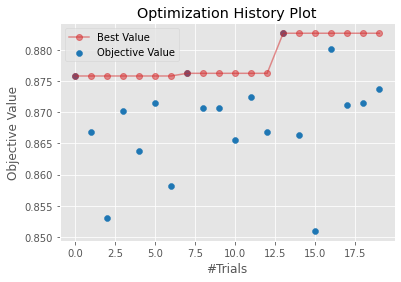

In [46]:
optuna.visualization.matplotlib.plot_optimization_history(cnn_study)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  """Entry point for launching an IPython kernel.


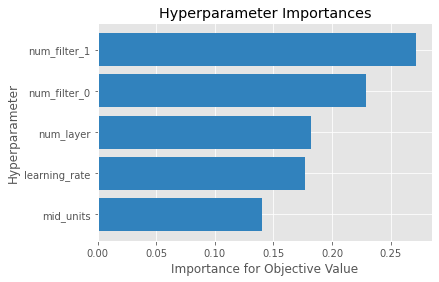

In [47]:
optuna.visualization.matplotlib.plot_param_importances(cnn_study)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  """Entry point for launching an IPython kernel.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3faf8f0ad0>,
      dtype=object)

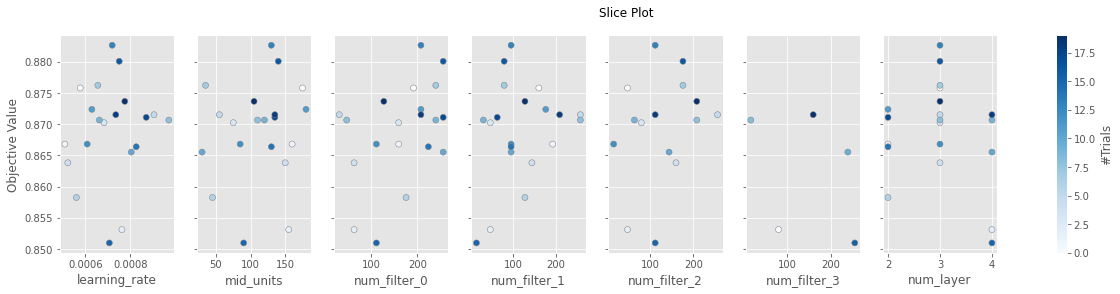

In [48]:
optuna.visualization.matplotlib.plot_slice(cnn_study)

### Training

In [49]:
cnn_acc = []
cnn_pred = np.zeros((test_X.shape[0], 4))
seed = 42
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
es = EarlyStopping(monitor = 'val_acc', patience = 5, mode = 'max', verbose = 0)

for i, (train_idx, val_idx) in enumerate(skf.split(train_X, train['target'])):
  print(f'{i+1} Fold Training......')
  X_tr, y_tr = train_X[train_idx], train_y[train_idx]
  X_val, y_val = train_X[val_idx], train_y[val_idx]

  cnn = create_model(cnn_study.best_params['num_layer'], cnn_study.best_params['mid_units'],
                     [cnn_study.best_params[f'num_filter_{i}'] for i in range(cnn_study.best_params['num_layer'])])
  
  # ModelCheckPoint Fold마다 갱신
  mc = ModelCheckpoint(f'model_{i+1}.h5', save_best_only = True, monitor = 'val_acc', mode = 'max', verbose = 0)

  # 모델 Compile
  optimizer = Adam(learning_rate = cnn_study.best_params['learning_rate'])
  cnn.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])
  cnn.fit(X_tr, y_tr, validation_data = (X_val, y_val), epochs = 100, batch_size = 32, callbacks = [es, mc], verbose = 0)

  # 최고 성능 모델 기록
  best = load_model(f'model_{i+1}.h5')

  val_pred = best.predict(X_val)
  val_cls = np.argmax(val_pred, axis = 1)

  fold_cnn_acc = accuracy_score(np.argmax(y_val, axis = 1), val_cls)
  cnn_acc.append(fold_cnn_acc)
  print(f'{i+1} Fold Acc of CNN = {fold_cnn_acc}\n')

  fold_pred = best.predict(test_X) / skf.n_splits
  cnn_pred += fold_pred

1 Fold Training......
1 Fold Acc of CNN = 0.8779443254817987

2 Fold Training......
2 Fold Acc of CNN = 0.8993576017130621

3 Fold Training......
3 Fold Acc of CNN = 0.8758029978586723

4 Fold Training......
4 Fold Acc of CNN = 0.8501070663811563

5 Fold Training......
5 Fold Acc of CNN = 0.8758029978586723



In [50]:
np.mean(cnn_acc)

0.8758029978586723

In [51]:
submission['target'] = np.argmax(cnn_pred, axis = 1)
submission.to_csv('Optuna_CNN7.csv', index = False)
submission['target'].value_counts()

2    2487
1    2464
3    2297
0    2095
Name: target, dtype: int64